In [1]:
from platform import python_version

print(python_version())

3.8.10


In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
from tensorflow import keras
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.python.keras.layers.wrappers import Bidirectional
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50

2022-01-08 16:24:01.821000: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-08 16:24:01.821036: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
import glob
images_path = r'/home/saba/Downloads/Dataset/Flicker8k_Dataset'
images = glob.glob(images_path + '/*.jpg')

len(images)

8091

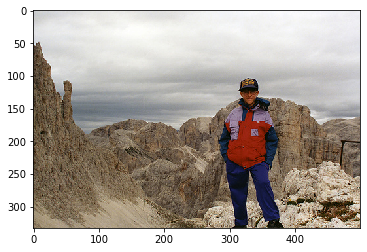

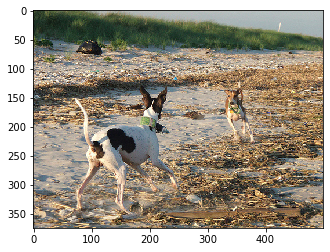

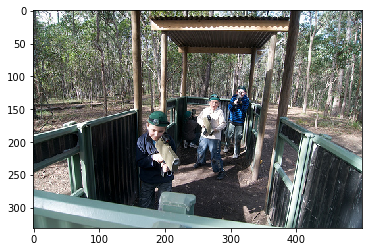

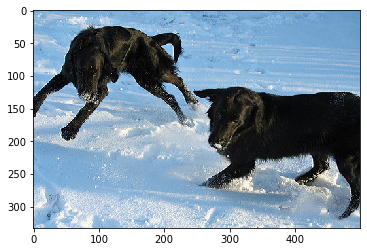

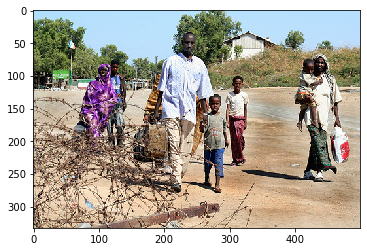

In [4]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [5]:
incept_model = ResNet50(include_top=True)

2022-01-08 16:24:09.847720: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-08 16:24:09.847792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-08 16:24:09.847844: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (saba-Inspiron-5720): /proc/driver/nvidia/version does not exist


In [6]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [8]:
caption_path = r"/home/saba/Downloads/Dataset/Flicker8k_text/Flickr8k.token.txt"
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')
len(captions)

40461

In [9]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass
len(captions_dict)

1500

/home/saba/Downloads/Dataset/Flicker8k_Dataset/1394620454_bf708cc501.jpg


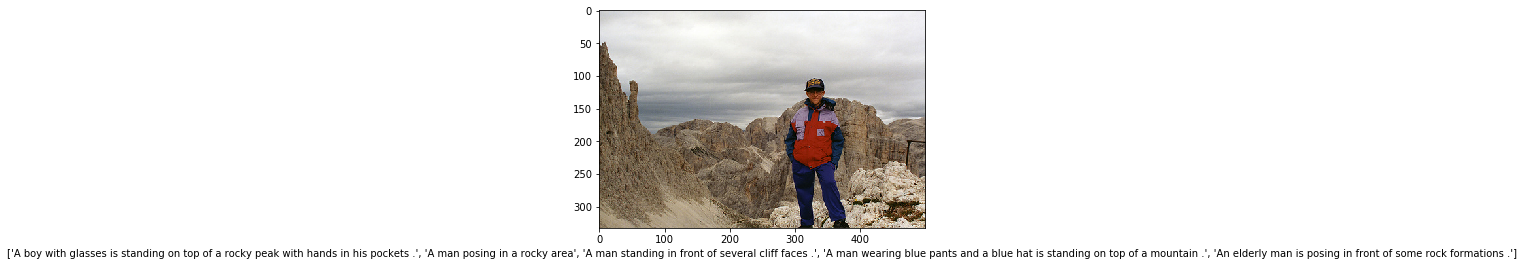

In [10]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = r'/home/saba/Downloads/Dataset/Flicker8k_Dataset/' + k
    print(img_name)
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break
    
    

In [11]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified


In [12]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)


In [13]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [14]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [15]:
new_dict['<OUT>'] = len(new_dict) 

captions_backup = captions_dict.copy()

captions_dict = captions_backup.copy()


In [16]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

captions_dict



{'1001773457_577c3a7d70.jpg': [[1, 2, 3, 4, 5, 2, 6, 4, 7, 8, 9],
  [1, 2, 3, 4, 5, 2, 10, 4, 11, 12, 13, 14, 15, 16, 17, 18, 9],
  [1, 2, 3, 4, 5, 2, 19, 4, 12, 20, 21, 7, 22, 23, 13, 14, 24, 16, 25, 18, 9],
  [1, 26, 27, 28, 29, 30, 31, 23, 13, 14, 15, 16, 17, 18, 9],
  [1, 26, 27, 15, 32, 33, 34, 13, 14, 18, 9]],
 '1009434119_febe49276a.jpg': [[1,
   2,
   3,
   5,
   19,
   4,
   35,
   36,
   24,
   2,
   37,
   38,
   39,
   40,
   2,
   19,
   41,
   18,
   9],
  [1, 2, 3, 5, 19, 4, 35, 36, 42, 16, 43, 18, 9],
  [1, 2, 44, 45, 35, 36, 24, 16, 43, 18, 9],
  [1, 2, 44, 45, 35, 36, 15, 46, 47, 43, 24, 48, 28, 2, 19, 41, 18, 9],
  [1, 2, 4, 49, 15, 16, 47, 43, 50, 2, 51, 41, 18, 9]],
 '101654506_8eb26cfb60.jpg': [[1, 2, 20, 5, 19, 4, 35, 36, 42, 16, 52, 18, 9],
  [1, 2, 4, 35, 36, 24, 16, 52, 9],
  [1, 2, 4, 36, 42, 52, 18, 9],
  [1, 2, 19, 5, 20, 4, 35, 36, 42, 2, 52, 53, 54, 18, 9],
  [1, 16, 19, 5, 20, 4, 35, 36, 55, 16, 56, 28, 16, 52, 18, 9]],
 '1019604187_d087bf9a5f.jpg': [[1,

In [17]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)


[1, 2, 3, 4, 5, 2, 6, 4, 7, 8, 9]
[1, 2, 3, 4, 5, 2, 10, 4, 11, 12, 13, 14, 15, 16, 17, 18, 9]
[1, 2, 3, 4, 5, 2, 19, 4, 12, 20, 21, 7, 22, 23, 13, 14, 24, 16, 25, 18, 9]
[1, 2, 74, 35, 118, 16, 119, 28, 2, 111, 120, 58, 121, 68, 24, 48, 28, 122, 108, 115, 116, 74, 117, 15, 18, 9]
[1, 2, 74, 24, 102, 377, 139, 544, 545, 2, 186, 137, 180, 16, 72, 15, 102, 546, 547, 28, 164, 15, 102, 548, 220, 18, 9]
[1, 2, 111, 24, 102, 377, 443, 5, 632, 35, 836, 15, 2, 238, 517, 115, 2, 579, 111, 24, 2, 301, 139, 149, 91, 58, 144, 15, 16, 517, 837, 144, 838, 839, 9]
[1, 2, 174, 874, 111, 287, 2, 20, 139, 5, 875, 876, 5, 2, 877, 74, 287, 2, 47, 485, 5, 80, 632, 12, 2, 338, 715, 131, 236, 23, 16, 878, 28, 16, 879, 18, 9]


In [18]:
MAX_LEN
captions_dict

{'1001773457_577c3a7d70.jpg': [[1, 2, 3, 4, 5, 2, 6, 4, 7, 8, 9],
  [1, 2, 3, 4, 5, 2, 10, 4, 11, 12, 13, 14, 15, 16, 17, 18, 9],
  [1, 2, 3, 4, 5, 2, 19, 4, 12, 20, 21, 7, 22, 23, 13, 14, 24, 16, 25, 18, 9],
  [1, 26, 27, 28, 29, 30, 31, 23, 13, 14, 15, 16, 17, 18, 9],
  [1, 26, 27, 15, 32, 33, 34, 13, 14, 18, 9]],
 '1009434119_febe49276a.jpg': [[1,
   2,
   3,
   5,
   19,
   4,
   35,
   36,
   24,
   2,
   37,
   38,
   39,
   40,
   2,
   19,
   41,
   18,
   9],
  [1, 2, 3, 5, 19, 4, 35, 36, 42, 16, 43, 18, 9],
  [1, 2, 44, 45, 35, 36, 24, 16, 43, 18, 9],
  [1, 2, 44, 45, 35, 36, 15, 46, 47, 43, 24, 48, 28, 2, 19, 41, 18, 9],
  [1, 2, 4, 49, 15, 16, 47, 43, 50, 2, 51, 41, 18, 9]],
 '101654506_8eb26cfb60.jpg': [[1, 2, 20, 5, 19, 4, 35, 36, 42, 16, 52, 18, 9],
  [1, 2, 4, 35, 36, 24, 16, 52, 9],
  [1, 2, 4, 36, 42, 52, 18, 9],
  [1, 2, 19, 5, 20, 4, 35, 36, 42, 2, 52, 53, 54, 18, 9],
  [1, 16, 19, 5, 20, 4, 35, 36, 55, 16, 56, 28, 16, 52, 18, 9]],
 '1019604187_d087bf9a5f.jpg': [[1,

In [19]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

In [20]:
X, y_in, y_out = generator(images_features, captions_dict)

len(X), len(y_in), len(y_out)



(96335, 96335, 96335)

In [21]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

X.shape, y_in.shape, y_out.shape

X[1510]

y_in[2]


array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [22]:
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate


In [23]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 37, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 37, 128)           508672    
                                                                 
 lstm (LSTM)                 (None, 37, 256)           394240    
                            

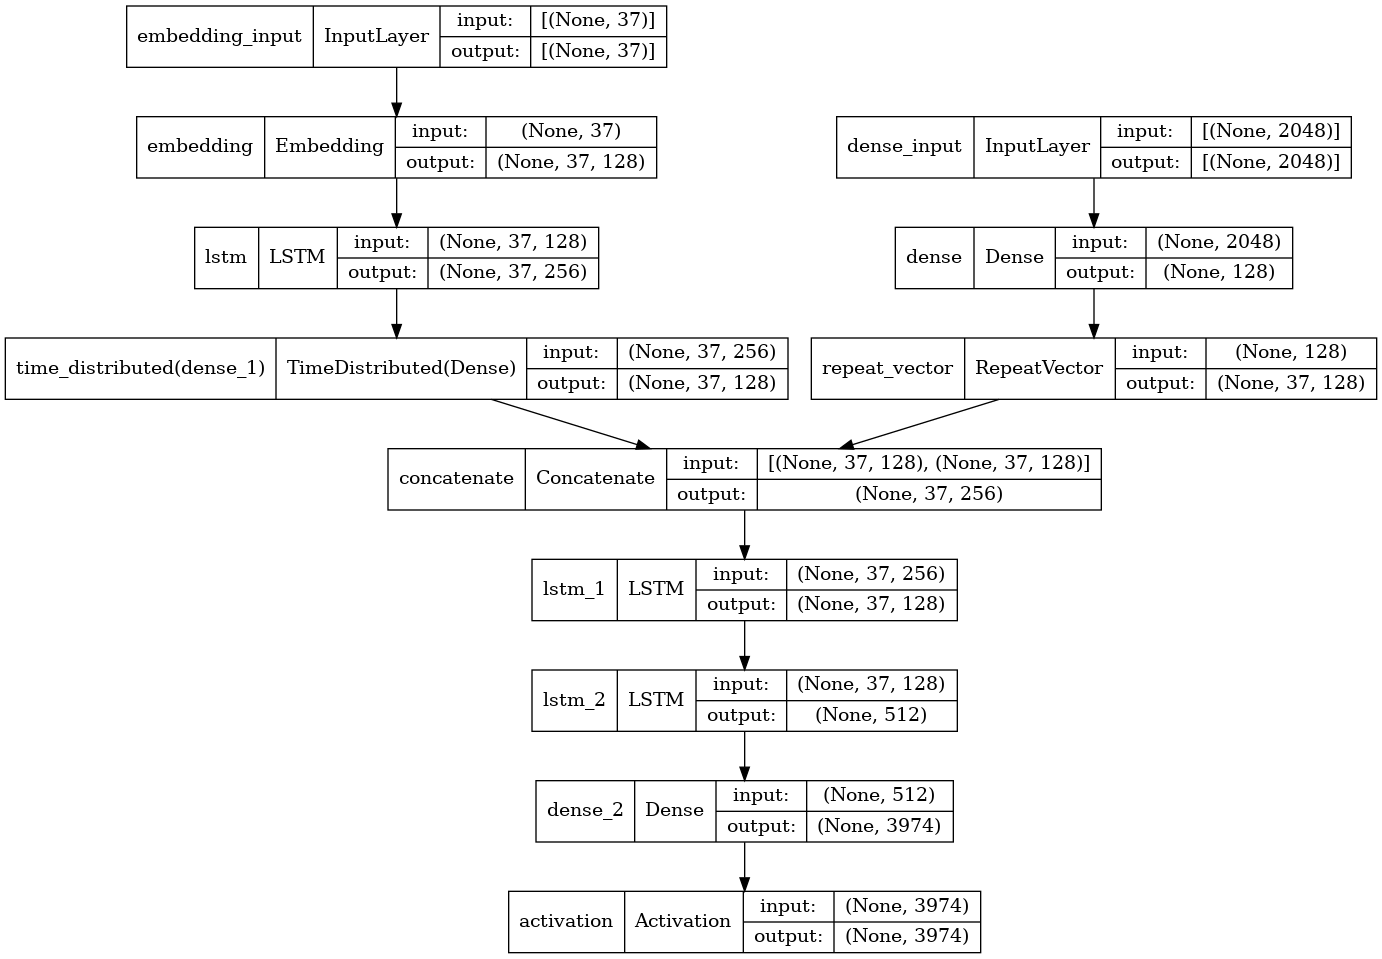

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model , show_shapes=True)

In [1]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

NameError: name 'model' is not defined